# Image Classifier: 11 Food

The dataset can be found on Kaggle "https://www.kaggle.com/datasets/trolukovich/food11-image-dataset".
It contains of 16643 images split in 11 unbalanced categories.

In this project I will rebuilt a small (~2.4 mio parameters) model from the "Vegetable Image Classifier" and use some pretrained models for transfer learning in comparision  

## Imports and global settings

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
from tensorflow.keras import mixed_precision
import sklearn as sk
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


In [2]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [3]:
print(tf.config.list_physical_devices())
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
2.10.0


In [4]:
train_dir = r"D:\Datasets\11food\train"
val_dir = r"D:\Datasets\11food\validate"
test_dir = r"D:\Datasets\11food\test"

In [5]:
checkpoint_path = r'C:\Users\neema\Coding\Portfolio_Projects\ComputerVision\11food_checkpoints'

## Data Loaders

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    rotation_range=0.2,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    horizontal_flip=True)

test_val_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                    batch_size=32,
                                    target_size=(224,224),
                                    class_mode='categorical',
                                    shuffle =True,
                                    seed=42)

val_data = test_val_datagen.flow_from_directory(directory=val_dir,
                                            batch_size=32,
                                            target_size=(224,224),
                                            shuffle = True,
                                            class_mode='categorical')
                                            
test_data = test_val_datagen.flow_from_directory(directory=test_dir,
                                            batch_size=32,
                                            target_size=(224,224),
                                            shuffle = True,
                                            class_mode='categorical')

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


## Data exploration

In [7]:
# a function to see image augmentation
def augment_image(data_gen, k=8):
    plt.figure(figsize=(12,6))
    rand = np.random.randint(0,32)

    for i in range(k):
        pics = data_gen[0][0]
        plt.subplot(2,k//2, i+1)
        plt.imshow(pics[rand])
        plt.axis('off')

In [8]:
classes = os.listdir(train_dir)

print(classes)

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


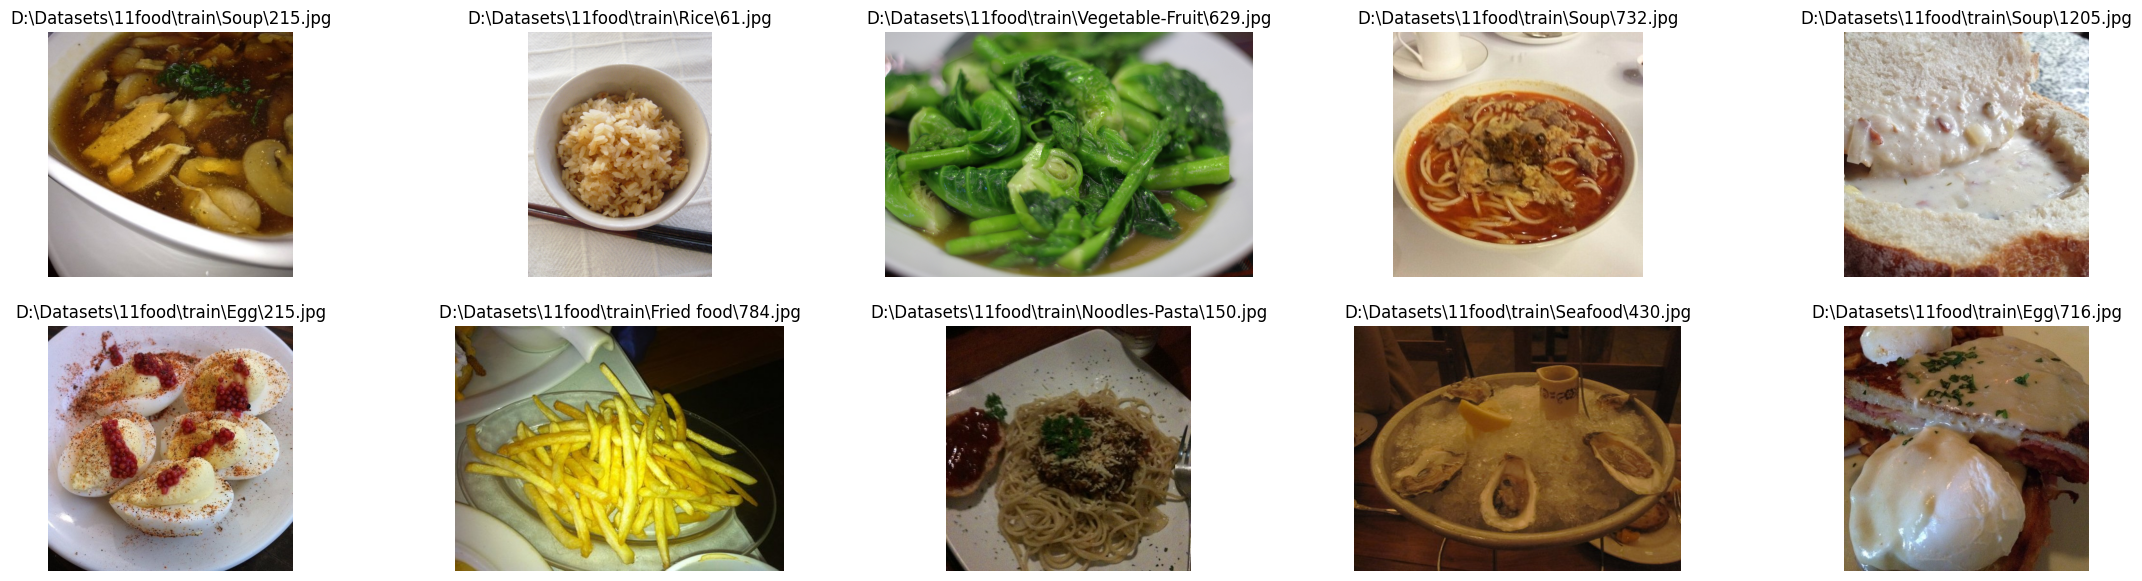

In [9]:
def random_image(path=train_dir, classes=classes, x=10):

    plt.figure(figsize=(28,7))

    for i in range(x):
        random_class = np.random.choice(classes)
        folder = os.path.join(train_dir, random_class)
        random_pic = np.random.choice(os.listdir(folder))

        random_pic = os.path.join(folder, random_pic)
        img = mpimg.imread(random_pic)

        plt.subplot(2, int(x/2), i+1)
        plt.imshow(img)
        plt.title(f"{random_pic}")
        plt.axis('off')

random_image()


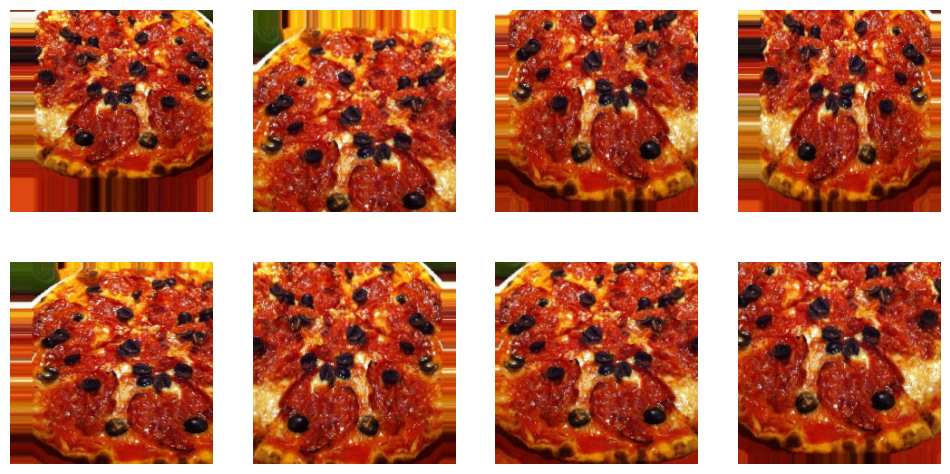

In [10]:
augment_image(train_data)

## Callbacks and train_function

In [11]:
# saving model checkpoints
def chckpt(name):
    model_chckpt = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path,name),
                                        save_best_only =True,
                                        save_weights_only = False,
                                        monitor='val_accuracy')
    return model_chckpt

# learning rate scheduler
def scheduler(epoch, lr):
    if epoch <15:
        return lr
    elif epoch < 35:
        return lr*0.99
    elif epoch <50:
        return lr* 0.95
    else:
        return lr * 0.90

lr_update = tf.keras.callbacks.LearningRateScheduler(scheduler)

# early stopping
early_stop =tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.005, patience=20, verbose=0, # min_delta = 0.005 -> accuracy of validation data has to improve by at least 0.5%
    mode='auto', baseline=None, restore_best_weights=False)


# train fucntion
def model_fit(data, checkpoint_path, model, epochs = 50):
    
    file = f"history_{model.name}.csv"
    path = os.path.join(checkpoint_path, model.name, file)
    
    if os.path.exists(os.path.join(checkpoint_path, model.name)):
        model = tf.keras.models.load_model(os.path.join(checkpoint_path, model.name))
        hist = pd.read_csv(path, index_col=0)
    else:
        hist = model.fit(data,
               epochs = epochs,
               steps_per_epoch = len(data),
               validation_data = val_data,
               validation_steps= len(val_data),
                verbose=1,
               callbacks=[chckpt(model.name), lr_update, early_stop])
        model = tf.keras.models.load_model(os.path.join(checkpoint_path, model.name))
        hist = pd.DataFrame(hist.history)
        hist.to_csv(path)
        
    return model, hist

### Confusion matrix

In [12]:
def confmatrix_from_datagen(data_gen, model, frac = 1.):
    predictions = []
    targets = []
    i = 0
    n_images = 0

    for x,ytrue in data_gen:
        # i +=1
        # n_images +=len(ytrue)
    
        yhat = model.predict(x)
        yhat = np.argmax(yhat, axis=1)
        ytrue = np.argmax(ytrue, axis=1)
        predictions = np.concatenate((predictions, yhat))
        targets = np.concatenate((targets, ytrue))
        if len(targets) >= int(np.ceil(data_gen.samples * frac)):
            break

    cm = confusion_matrix(targets, predictions)
    acc_dic = {k:0 for k in classes}

    for i in range(len(classes)):
        true = cm[i,i]
        full = cm[i,:].sum()
        acc = true/full
        acc_dic[classes[i]] = acc

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    #plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt="d", mask=cm==0, xticklabels= classes, yticklabels=classes)
    plt.title(f"CM of {model.name}. Tested {len(targets)} images.")

    plt.subplot(1,2,2)
    plt.bar(height= acc_dic.values(), x=acc_dic.keys())
    plt.xticks(rotation= 45)
    plt.title(f"accuracy of {model.name} by category")
    
    return cm

## Models

### model_0: 
this model is the baseline model from the Vegetable Image Classifier notebook

In [12]:
inputs = layers.Input(shape=(224,224,3))
x = layers.Conv2D(filters = 16, kernel_size= 5, activation = "relu")(inputs)
x = layers.Conv2D(filters = 32, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 64, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 64, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters = 256, kernel_size= 3, activation = "relu")(x)
x = layers.Conv2D(filters = 256, kernel_size= 3, activation = "relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(classes), activation = "softmax")(x)

model_0 = tf.keras.Model(inputs, outputs, name="model_0")

model_0.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics='accuracy')

model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 105, 105, 64)      36928     
                                                           

In [13]:
file = f"history_{model_0.name}.csv"
file

'history_model_0.csv'

In [14]:
model_0, hist_m0 = model_fit(train_data, checkpoint_path, model_0)

### vgg16

Using the pretrained vgg16 model with the last two Conv blocks trainable for fine tuning. The classifier is the same as for model_0

In [18]:
vgg16_feature = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                weights = 'imagenet',
                                                input_shape=(224,224,3))

for l in vgg16_feature.layers[:-2]:
    l.trainable = False

vgg16_feature.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
inputs = layers.Input(shape= vgg16_feature.output.get_shape()[1:])
x = layers.Flatten()(inputs)
outputs = layers.Dense(len(classes), activation = 'softmax')(x)

head = tf.keras.Model(inputs, outputs, name= 'head')

head.summary()

Model: "head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 11)                275979    
                                                                 
Total params: 275,979
Trainable params: 275,979
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_vgg16 = tf.keras.Sequential([
    vgg16_feature,
    head
], name="model_vgg16")

model_vgg16.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics='accuracy')


model_vgg16.summary()

Model: "model_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 head (Functional)           (None, 11)                275979    
                                                                 
Total params: 14,990,667
Trainable params: 2,635,787
Non-trainable params: 12,354,880
_________________________________________________________________


In [21]:
model_vgg16, hist_vgg16 = model_fit(train_data, checkpoint_path, model_vgg16, 50)

### Xcexption

In [22]:
xception_feature = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3))


for l in xception_feature.layers[:-6]: # unfreezing the last two sepconv2d layers
    l.trainable = False

xception_feature.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [23]:
for i, l in enumerate(xception_feature.layers):
    if l.trainable:
        print(f"{i:>5}: " + str(l))

  126: <keras.layers.convolutional.SeparableConv2D object at 0x00000200206E1180>
  127: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002035063D9C0>
  128: <keras.layers.core.activation.Activation object at 0x00000200206F0940>
  129: <keras.layers.convolutional.SeparableConv2D object at 0x00000200206DEAD0>
  130: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000020020727FD0>
  131: <keras.layers.core.activation.Activation object at 0x000002002072C430>


In [24]:
inputs = layers.Input(shape= xception_feature.output.get_shape()[1:])
x = layers.Flatten()(inputs)
outputs = layers.Dense(len(classes), activation = 'softmax')(x)

head = tf.keras.Model(inputs, outputs, name= 'head')

head.summary()

model_xception = tf.keras.Sequential([
    xception_feature,
    head
], name="model_xception")

model_xception.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics='accuracy')


model_xception.summary()

Model: "head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 11)                1103883   
                                                                 
Total params: 1,103,883
Trainable params: 1,103,883
Non-trainable params: 0
_________________________________________________________________
Model: "model_xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 head (Functional)          

In [25]:
model_xception, hist_xception = model_fit(train_data, checkpoint_path, model_xception, 50)

## Evaluation

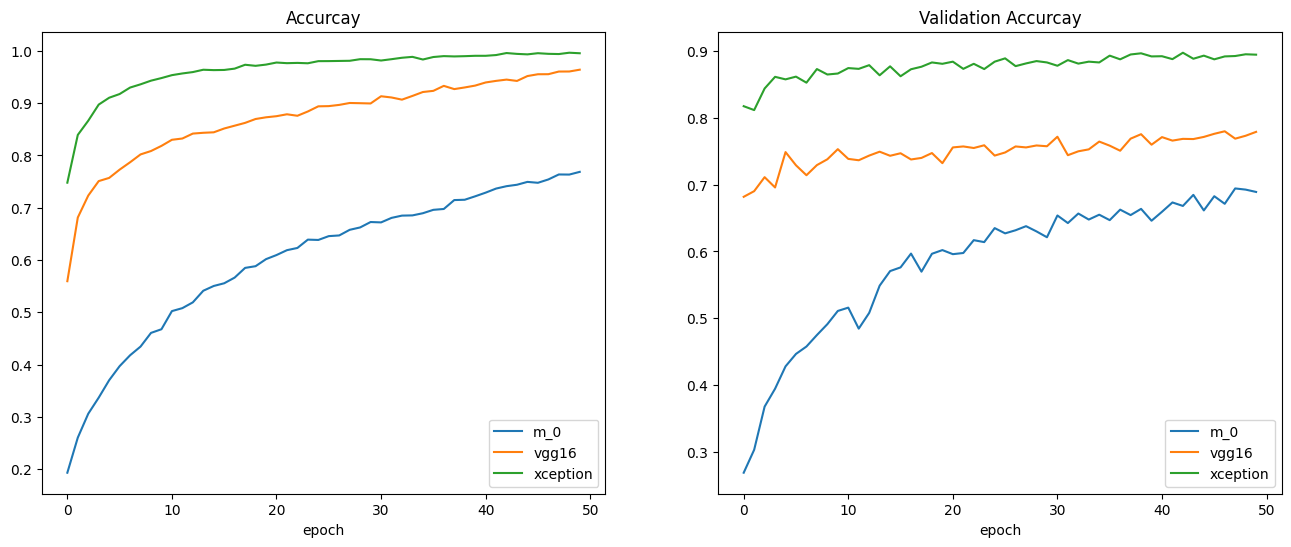

In [37]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(hist_m0['accuracy'], label='m_0')
plt.plot(hist_vgg16['accuracy'], label='vgg16')
plt.plot(hist_xception['accuracy'], label='xception')
plt.title('Accurcay')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_m0['val_accuracy'], label='m_0')
plt.plot(hist_vgg16['val_accuracy'], label='vgg16')
plt.plot(hist_xception['val_accuracy'], label='xception')
plt.title('Validation Accurcay')
plt.xlabel('epoch')
plt.legend()

In [26]:
model_0.evaluate(test_data)
model_vgg16.evaluate(test_data)
model_xception.evaluate(test_data)

105/105 [==============================] - 12s 105ms/step - loss: 0.6199 - accuracy: 0.9095


[0.6198752522468567, 0.9094711542129517]

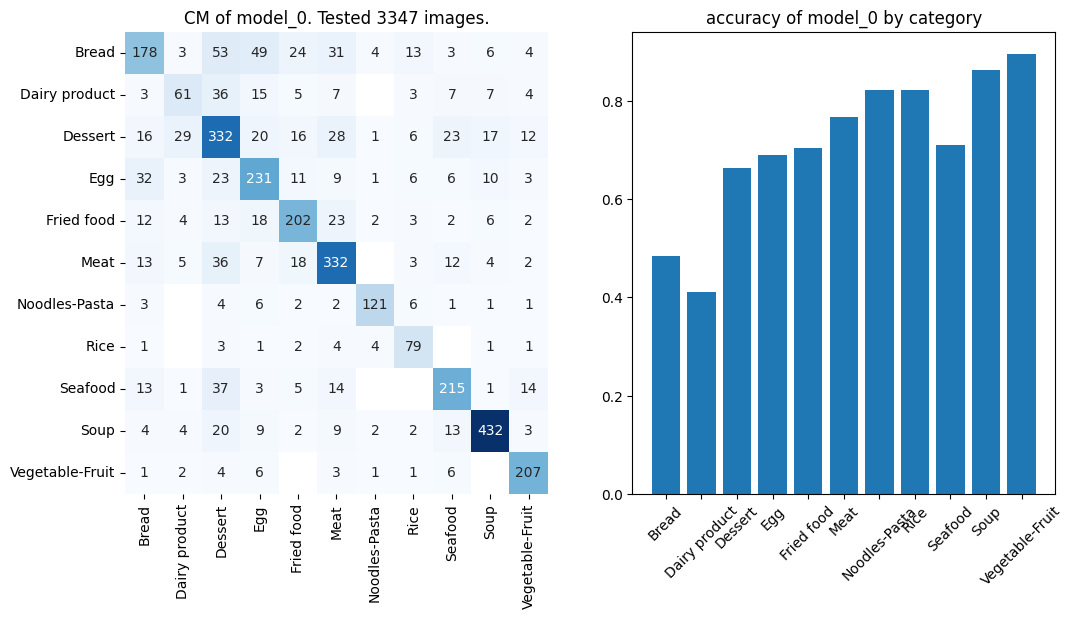

In [38]:
_ = confmatrix_from_datagen(test_data, model_0)

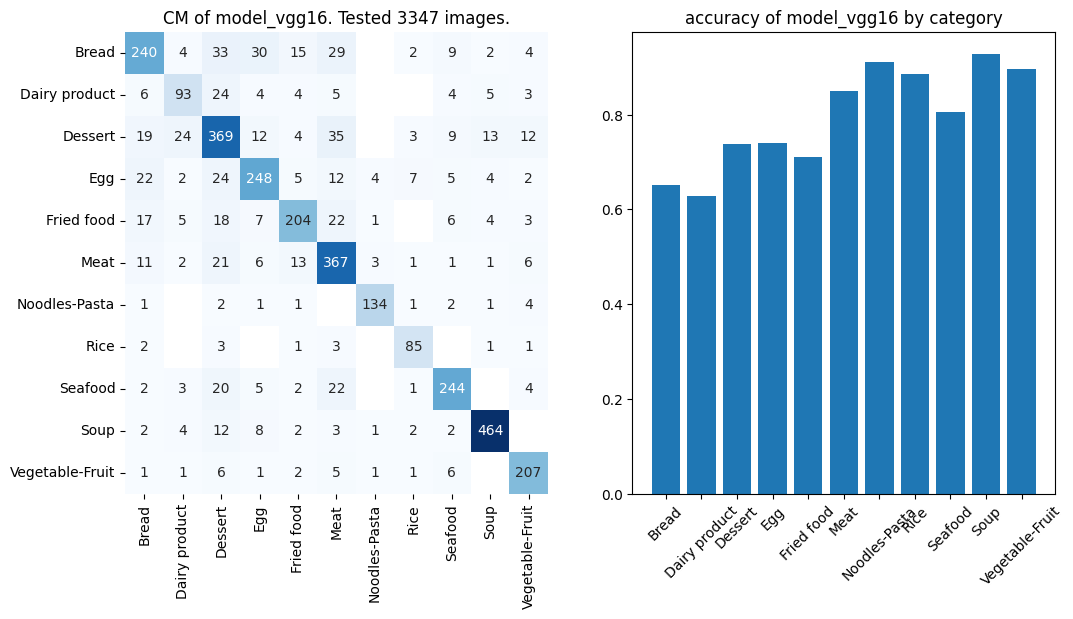

In [39]:
_ = confmatrix_from_datagen(test_data, model_vgg16)

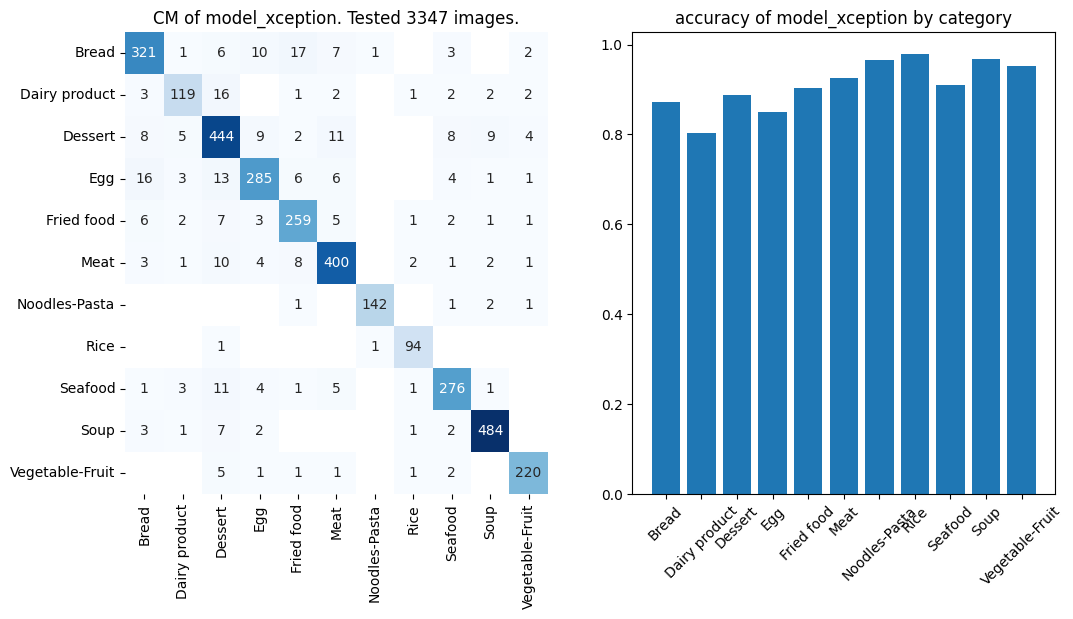

In [40]:
_ = confmatrix_from_datagen(test_data, model_xception)